# 모듈 임포트 및 데이터 로드

In [1]:
!pip install prophet --upgrade

In [2]:
!pip install prophet

In [3]:
!pip install pystan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 1.3 MB/s eta 0:00:00


In [4]:
from tqdm.auto import tqdm
import random
import os

import torch

import pandas as pd
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
import numpy as np
import pandas as pd

In [5]:
def reset_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

reset_seeds()

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [7]:
!pip install -U finance-datareader

In [8]:
import FinanceDataReader as fdr

In [9]:
df_krx = fdr.StockListing('KRX')
df_krx.head()

,Code,ISU_CD,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId
0,005930,KR7005930003,삼성전자,KOSPI,,74600,2,-200,-0.27,74600,75000,74300,7269457,542483572900,445345778230000,5969782550,STK
1,000660,KR7000660001,SK하이닉스,KOSPI,,138800,2,-1700,-1.21,139200,139900,138100,1437698,199610009500,101046728262000,728002365,STK
2,373220,KR7373220003,LG에너지솔루션,KOSPI,,426000,2,-6500,-1.50,428500,430000,424000,113386,48437717500,99684000000000,234000000,STK
3,207940,KR7207940008,삼성바이오로직스,KOSPI,,712000,2,-7000,-0.97,715000,720000,710000,18198,12997408000,50675888000000,71174000,STK
4,005935,KR7005931001,삼성전자우,KOSPI,,59800,1,100,0.17,59500,59900,59400,425305,25368301800,49208624660000,822886700,STK


In [10]:
df_krx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2785 entries, 0 to 2784
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Code         2785 non-null   object 
 1   ISU_CD       2785 non-null   object 
 2   Name         2785 non-null   object 
 3   Market       2785 non-null   object 
 4   Dept         2785 non-null   object 
 5   Close        2785 non-null   object 
 6   ChangeCode   2785 non-null   object 
 7   Changes      2785 non-null   int64  
 8   ChagesRatio  2785 non-null   float64
 9   Open         2785 non-null   int64  
 10  High         2785 non-null   int64  
 11  Low          2785 non-null   int64  
 12  Volume       2785 non-null   int64  
 13  Amount       2785 non-null   int64  
 14  Marcap       2785 non-null   int64  
 15  Stocks       2785 non-null   int64  
 16  MarketId     2785 non-null   object 
dtypes: float64(1), int64(8), object(8)
memory usage: 370.0+ KB


In [11]:
df_kospi = df_krx[df_krx['Market'] == 'KOSPI']
df_kospi

,Code,ISU_CD,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId
0,005930,KR7005930003,삼성전자,KOSPI,,74600,2,-200,-0.27,74600,75000,74300,7269457,542483572900,445345778230000,5969782550,STK
1,000660,KR7000660001,SK하이닉스,KOSPI,,138800,2,-1700,-1.21,139200,139900,138100,1437698,199610009500,101046728262000,728002365,STK
2,373220,KR7373220003,LG에너지솔루션,KOSPI,,426000,2,-6500,-1.50,428500,430000,424000,113386,48437717500,99684000000000,234000000,STK
3,207940,KR7207940008,삼성바이오로직스,KOSPI,,712000,2,-7000,-0.97,715000,720000,710000,18198,12997408000,50675888000000,71174000,STK
4,005935,KR7005931001,삼성전자우,KOSPI,,59800,1,100,0.17,59500,59900,59400,425305,25368301800,49208624660000,822886700,STK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2768,002785,KR7002781003,진흥기업우B,KOSPI,,4880,2,-100,-2.01,4980,4980,4880,85,414930,4183223840,857218,STK
2769,000227,KR7000222000,유유제약2우B,KOSPI,,12760,2,-230,-1.77,12810,12850,12710,5306,67868250,4154145600,325560,STK
2773,002787,KR7002782001,진흥기업2우B,KOSPI,,12750,1,250,2.00,12590,12750,12590,51,650090,3758802000,294808,STK
2774,001525,KR7001521004,동양우,KOSPI,,6070,2,-70,-1.14,6060,6080,6050,882,5343370,3749627170,617731,STK


In [30]:
def get_stock_data(item_name, year=2023):
    df_krx = fdr.StockListing('KRX')
    df_kospi = df_krx[df_krx['Market'] == 'KOSPI']

    def item_code_by_item_name(item_name):
        item_code_list = df_kospi.loc[df_kospi["Name"] == item_name, "Code"].tolist()
        if len(item_code_list) > 0:
            item_code = item_code_list[0]
            return item_code
        else:
            return None

    def find_item_list(item_name, year=2023):
        item_code = item_code_by_item_name(item_name)
        if item_code:
            df_day = fdr.DataReader(item_code, str(year))
            return df_day
        else:
            return None

    df = find_item_list(item_name, year)
    return df

# 모델 세팅 및 학습, 예측

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [14]:
def preprocess_data(df):
    data = df['Close'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(data)
    return scaled

def train_prophet_model(df, days_to_predict):
    df['ds'] = pd.to_datetime(df.index)
    df['y'] = df['Close']

    # 주말을 제외한 사용자 정의 휴일 데이터프레임 생성
    holidays = pd.DataFrame({
        'holiday': 'weekday',
        'ds': pd.date_range(start=df['ds'].min(), end=df['ds'].max(), freq='B')
    })

    model = Prophet(daily_seasonality=True, holidays=holidays)
    model.fit(df[['ds', 'y']])

    # 'B' 주기를 사용하여 평일만 예측하도록 future 데이터프레임 생성
    future = model.make_future_dataframe(periods=days_to_predict, freq='B')
    forecast = model.predict(future)

    # 실제값과 예측값 추출
    y_true = df['y']
    y_pred = forecast['yhat'][:-days_to_predict]  # 예측값 중에서 실제값과 대응되는 부분만 선택

    # MAE와 MSE 계산
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)

    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean Squared Error (MSE): {mse}')

    return model, forecast

def plot_prophet_forecast(model, forecast):
    model.plot(forecast)
    plt.show()

def save_forecast_to_dataframe(df, forecast, stock_name):
    forecast_df = forecast[['ds', 'yhat']].tail(14).rename(columns={'ds': 'Date', 'yhat': 'Predicted_Close'})
    forecast_df['Stock'] = stock_name
    return forecast_df

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvy_b5ns3/8slx687a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvy_b5ns3/2m7ayhhf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44498', 'data', 'file=/tmp/tmpvy_b5ns3/8slx687a.json', 'init=/tmp/tmpvy_b5ns3/2m7ayhhf.json', 'output', 'file=/tmp/tmpvy_b5ns3/prophet_model47emhpxz/prophet_model-20231221033612.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:36:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:36:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Absolute Error (MAE): 1245.8722304779665
Mean Squared Error (MSE): 2334591.299272982


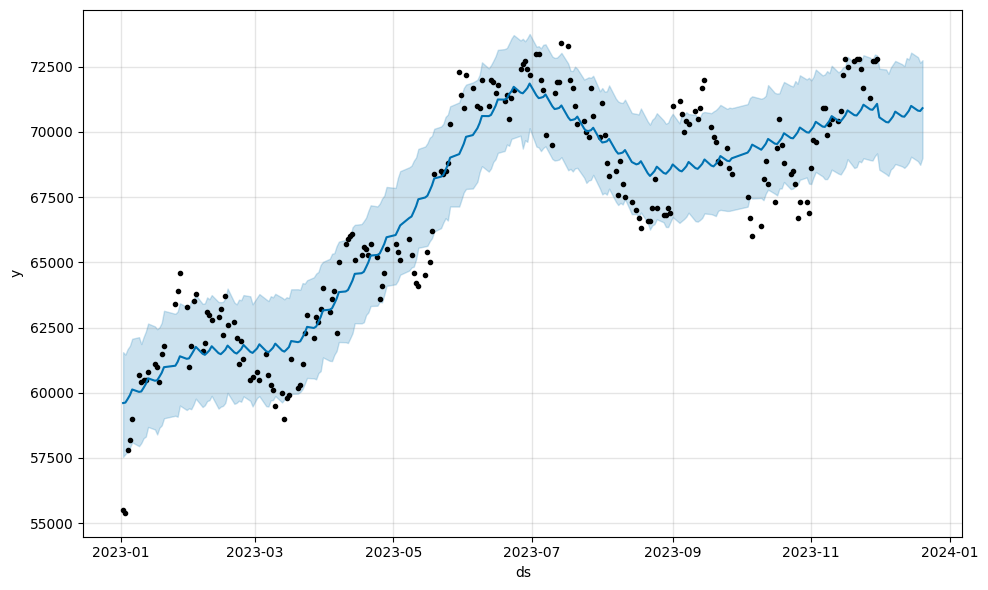

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvy_b5ns3/j5z1ks9l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvy_b5ns3/qrpd21es.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94836', 'data', 'file=/tmp/tmpvy_b5ns3/j5z1ks9l.json', 'init=/tmp/tmpvy_b5ns3/qrpd21es.json', 'output', 'file=/tmp/tmpvy_b5ns3/prophet_modeluutsybn0/prophet_model-20231221033624.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:36:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:36:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Absolute Error (MAE): 3551.350613021945
Mean Squared Error (MSE): 17892064.730505098


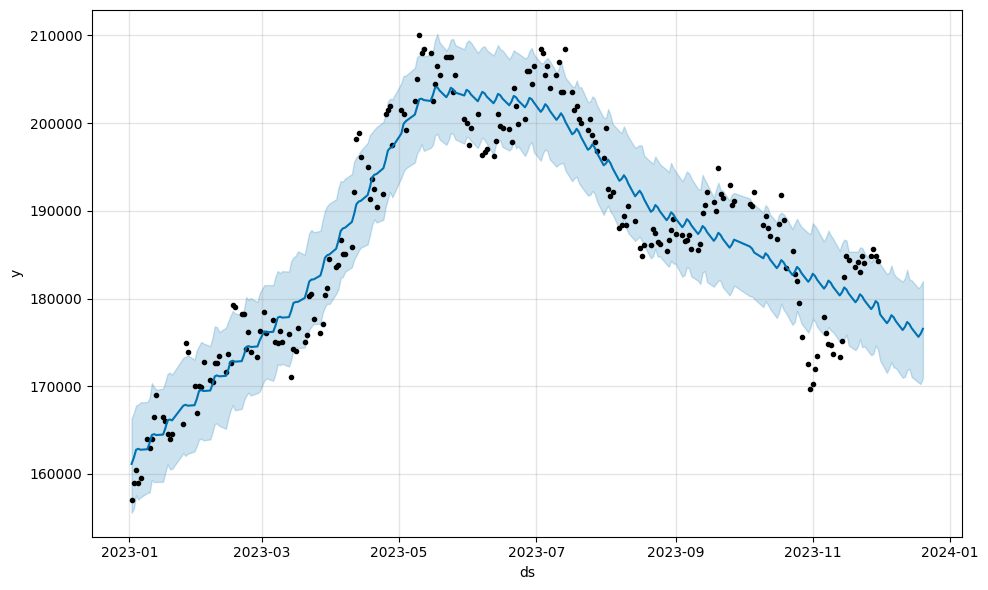

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvy_b5ns3/l73s9bcn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvy_b5ns3/7oq660p3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41584', 'data', 'file=/tmp/tmpvy_b5ns3/l73s9bcn.json', 'init=/tmp/tmpvy_b5ns3/7oq660p3.json', 'output', 'file=/tmp/tmpvy_b5ns3/prophet_modelk0i9f_66/prophet_model-20231221033633.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:36:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:36:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Absolute Error (MAE): 21684.85604092639
Mean Squared Error (MSE): 725841271.4901967


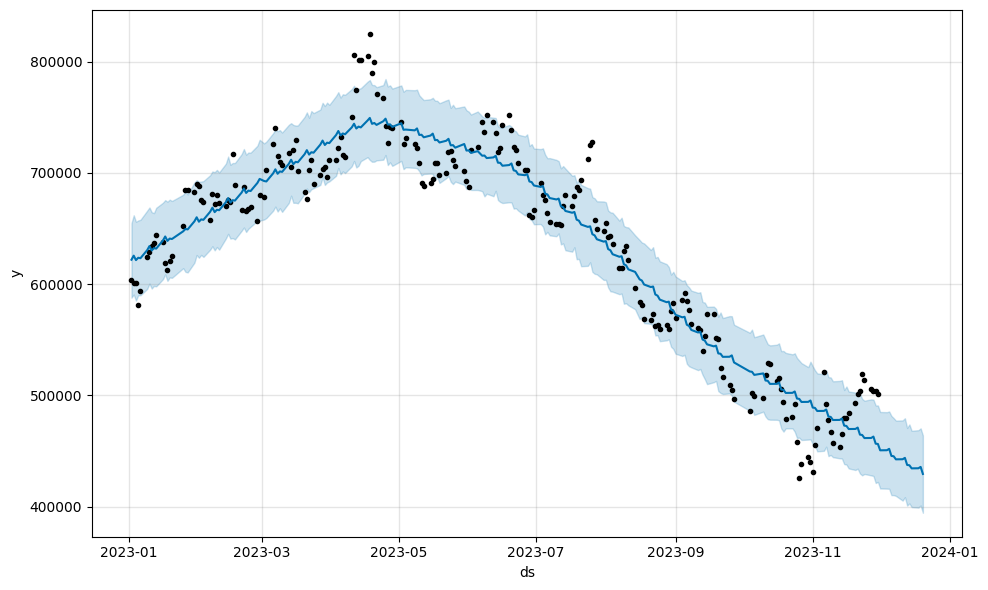

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvy_b5ns3/tp3ltiex.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvy_b5ns3/u_vu4kpp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22006', 'data', 'file=/tmp/tmpvy_b5ns3/tp3ltiex.json', 'init=/tmp/tmpvy_b5ns3/u_vu4kpp.json', 'output', 'file=/tmp/tmpvy_b5ns3/prophet_modelpztwjydf/prophet_model-20231221033651.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:36:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:36:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Absolute Error (MAE): 11087.9455598373
Mean Squared Error (MSE): 201859699.73472816


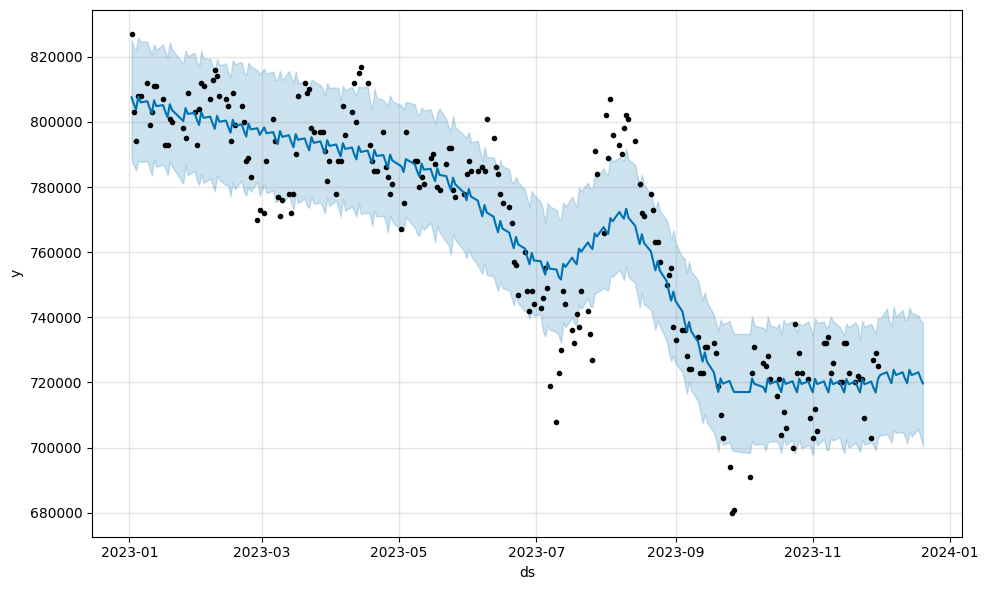

In [15]:
# 예측을 위한 주식 종목 리스트
stock_list = ["삼성전자", "현대차", "LG화학", "POSCO", "삼성바이오로직스"]
# stock_list = ["카카오"]
forecast_list = []

# 모든 주식 종목에 대한 예측 수행
for stock in stock_list:
    df_stock = get_stock_data(stock, year=2023)
    if df_stock is not None:
        scaled_data = preprocess_data(df_stock)

        # Train Prophet model
        model, forecast = train_prophet_model(df_stock, days_to_predict=14)

        # Plot forecast
        plot_prophet_forecast(model, forecast)

        # Save forecast to dataframe
        forecast_df = save_forecast_to_dataframe(df_stock, forecast, stock)
        forecast_list.append(forecast_df)

In [21]:
forecast_list[0]

,Date,Predicted_Close,Stock
226,2023-12-01,70559.097077,삼성전자
227,2023-12-04,70377.621195,삼성전자
228,2023-12-05,70364.068308,삼성전자
229,2023-12-06,70472.448080,삼성전자
230,2023-12-07,70591.646335,삼성전자
231,2023-12-08,70777.807671,삼성전자
232,2023-12-11,70596.331789,삼성전자
233,2023-12-12,70582.778902,삼성전자
234,2023-12-13,70691.158673,삼성전자
235,2023-12-14,70810.356929,삼성전자


In [17]:
data = forecast_list[0]

In [31]:
df_stock_REAL = get_stock_data("삼성전자", year=2023)

In [32]:
df_stock_REAL.reset_index(inplace=True)

In [33]:
df_stock_REAL= df_stock_REAL.tail(15)

In [34]:
df_stock_REAL

,Date,Open,High,Low,Close,Volume,Change
226,2023-12-01,72400,72500,71700,72000,9871284,-0.010989
227,2023-12-04,72800,72900,72400,72600,10229267,0.008333
228,2023-12-05,72300,72400,71200,71200,12129682,-0.019284
229,2023-12-06,71800,72100,71600,71700,8123087,0.007022
230,2023-12-07,71800,71900,71100,71500,8862017,-0.002789
231,2023-12-08,72100,72800,71900,72600,10859463,0.015385
232,2023-12-11,72800,73000,72200,73000,9861960,0.005510
233,2023-12-12,73300,73500,73100,73500,13758646,0.006849
234,2023-12-13,73300,73500,72800,72800,13116766,-0.009524
235,2023-12-14,74100,74300,72500,73100,27567593,0.004121


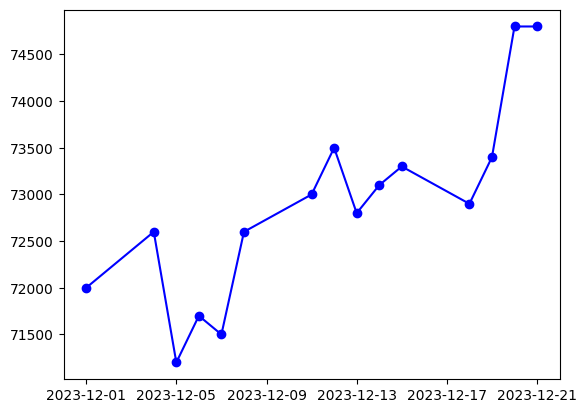

In [35]:
plt.plot(df_stock_REAL['Date'], df_stock_REAL['Close'], marker='o', linestyle='-', color='b')

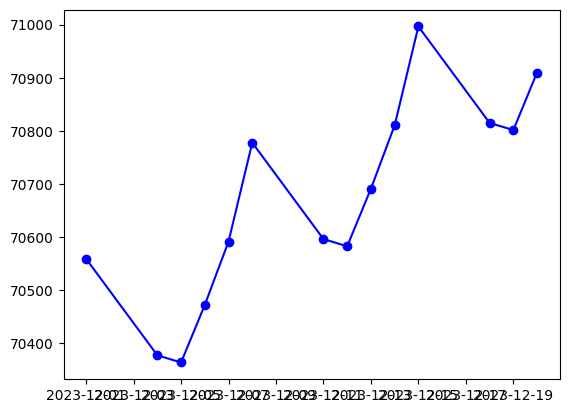

In [18]:
plt.plot(data['Date'], data['Predicted_Close'], marker='o', linestyle='-', color='b')

ConversionError: ignored

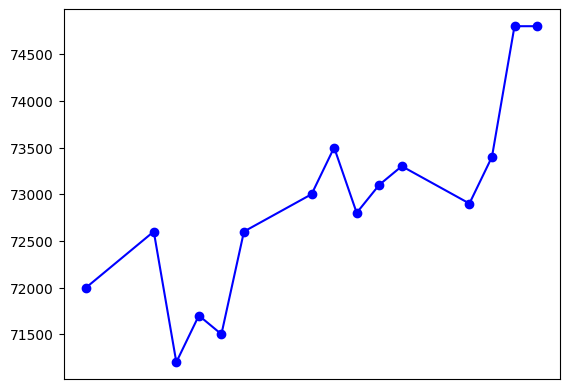

In [36]:
# 주식 실제 데이터 그래프
plt.plot(df_stock_REAL['Date'], df_stock_REAL['Close'], marker='o', linestyle='-', color='b', label='Real Close')

# 예측된 주식 데이터 그래프
plt.plot(data['Date'], data['Predicted_Close'], marker='o', linestyle='-', color='r', label='Predicted Close')

# 범례 추가
plt.legend()

# x축, y축 라벨 추가
plt.xlabel('Date')
plt.ylabel('Close Price')

# 그래프 타이틀 설정
plt.title('Real vs Predicted Close Prices')

# 그래프 표시
plt.show()

In [19]:
#  ver1

data = {
    'Date': [
        '2023-12-21', '2023-12-22', '2023-12-23', '2023-12-24', '2023-12-25',
        '2023-12-26', '2023-12-27', '2023-12-28', '2023-12-29', '2023-12-30',
        '2023-12-31', '2023-01-01', '2023-01-02', '2023-01-03'
    ],
    'Predicted_Close': [
        46009.484375, 45405.925781, 44846.480469, 44309.929688, 43796.953125,
        43307.390625, 42836.625000, 42385.113281, 41953.167969, 41540.640625,
        41147.382812, 40773.332031, 40417.859375, 40080.714844
    ]
}

# 데이터프레임 생성
df = pd.DataFrame(data)

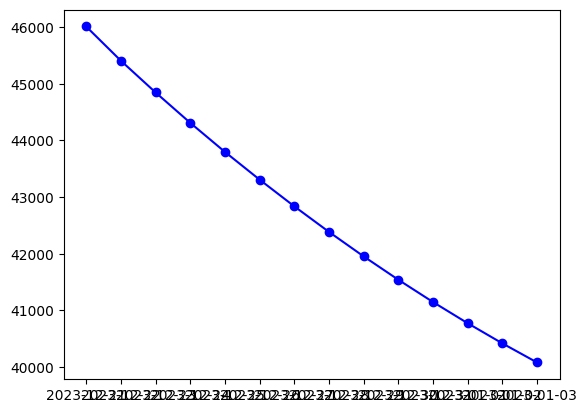

In [20]:
plt.plot(df['Date'], df['Predicted_Close'], marker='o', linestyle='-', color='b')